# Mourning tweets



In [444]:
import emoji
import pandas as pd
import numpy as np
import findspark
import glob
import os
import re
import nltk
import pickle
import spacy
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(print_changed_only=False)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [21]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# Inicializacion de spark

In [4]:
import findspark
localizacion_spark = '/opt/spark-2.4.5'
findspark.init(localizacion_spark)

import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType

# numero de cores: 4, memoria ram que se le permite a spark usar: 7GB
spark_configurations = SparkConf()\
    .setMaster('local[4]')\
    .setAppName('Tarea_2')\
    .set("spark.driver.memory", "7g")

sc = pyspark.SparkContext(conf = spark_configurations)


spark = SparkSession\
    .builder\
    .master('local[4]')\
    .appName("Tarea_2") \
    .getOrCreate()

# Lectura de datos

In [23]:
def lectura_tweets(file_path):
    tweets = pd\
        .read_csv(file_path, sep =',')\
        .reset_index()
    tweets_es = tweets.loc[tweets['lang']=='es']
    tweets_en = tweets.loc[tweets['lang']=='en']
    return [tweets_es, tweets_en]
def lectura_tweets_spark(file_path, spark_context):
    tweets = spark_context.read\
        .option("multiLine", True)\
        .option("header", True)\
        .option("escape", "\"")\
        .csv(os.path.join('datasets', 'fnmourning.csv'))
    tweets_es = tweets\
        .filter(col('lang')=='es')
    tweets_en = tweets\
        .filter(col('lang')=='en')
    return [tweets_es, tweets_en]

In [26]:
tweets_es, tweets_en = lectura_tweets(os.path.join('datasets', 'fnmourning.csv'))

# Construccion del lexicon de luto

## Tokenizacion

In [504]:
def limpiar_emoticones(x):
    res = x
    try: 
        res = re.search('(:(.*?):)',x).group(0)
    except:
        pass
    return res
def limpiar_docs(x):
    doc_limpio = \
        ' '.join(x
                 .lower()
                 .replace('@',' ')
                 .replace('#', ' ')
                 .replace('%', ' ')
                 .replace('&', ' ')
                 .replace("'", ' ')
                 .replace("*", ' ')
                 .replace("$", ' ')
                 .replace("+", ' ')
                 .replace("-", ' ')
                 .replace(":", ' ')
                 .replace("~", ' ')
                 .replace("|", ' ')
                 .replace("{", ' ')
                 .replace("}", ' ')
                 .replace("(", ' ')
                 .replace(")", ' ')
                 .replace("!", ' ')
                 .replace("¡", ' ')
                 .split())
    doc_limpio = emoji.emojize(str(emoji.demojize(doc_limpio).encode("unicode_escape"))[2:-1])
    doc_limpio = doc_limpio
    return doc_limpio
def tokenizacion_spanish_documento_nltk(doc):
    nltk_stop_words_es = set(nltk.corpus.stopwords.words("spanish"))
    stemmer_es = nltk.stem.SnowballStemmer("spanish")
    doc_limpio = limpiar_docs(doc)
    doc_p = nltk.word_tokenize(doc_limpio)
    doc_process = [emoji.demojize(stemmer_es.stem(word.strip()))
                   if 'covid' not in word else 'covid-19'
                   for word in doc_p 
                   if word not in nltk_stop_words_es
                   and ('https' not in word)
                   and ('\n' not in word)
                   and ('/' not in word)
                   and ('\\' not in word)
                   and ('y' != word)
                   and ('a' != word)
                   and ('o' != word)
                   and (':' not in word)
                   and (',' not in word)
                   and ('.' not in word)
                   and (';' not in word)
                   and ('``' not in word)
                   and ('(' not in word)
                   and (')' not in word)
                   and ('"' not in word)
                   and ("''" not in word)
                   and not( (any(char.isdigit() for char in word)) and ('covid' not in word))
                  ]
    doc_process_sin_emoticones = [word for word in doc_process if ':' not in word]
    doc_process_emoticones = [limpiar_emoticones(word) for word in doc_process if ':' in word]
    doc_process_limpio = doc_process_sin_emoticones + doc_process_emoticones
    return np.unique(doc_process_limpio)
def tokenizacion_english_documento_nltk(doc):
    nltk_stop_words_en = set(nltk.corpus.stopwords.words("english"))
    stemmer_en = nltk.stem.porter.PorterStemmer()
    doc_limpio = limpiar_docs(doc)
    doc_p = nltk.word_tokenize(doc_limpio)
    doc_process = [emoji.demojize(stemmer_en.stem(word.strip()))
                   if 'covid' not in word else 'covid-19'
                   for word in doc_p 
                   if word not in nltk_stop_words_en
                   and ('https' not in word)
                   and ('\n' not in word)
                   and ('/' not in word)
                   and ('\\' not in word)
                   and (':' not in word)
                   and (',' not in word)
                   and ('.' not in word)
                   and (';' not in word)
                   and ('``' not in word)
                   and ('(' not in word)
                   and (')' not in word)
                   and ('"' not in word)
                   and ("''" not in word)
                   and not( (any(char.isdigit() for char in word)) and ('covid' not in word))
                  ]
    doc_process_sin_emoticones = [word for word in doc_process if ':' not in word]
    doc_process_emoticones = [limpiar_emoticones(word) for word in doc_process if ':' in word]
    doc_process_limpio = doc_process_sin_emoticones + doc_process_emoticones
    return np.unique(doc_process_limpio)

def tokenizacion_spanish(tweets_df):
    res = tweets_df.copy()
    res['tokens'] = res['text'].apply(tokenizacion_spanish_documento_nltk)
    res  = res.explode('tokens', ignore_index = True).dropna()
    return res
def tokenizacion_english(tweets_df):
    res = tweets_df.copy()
    res['tokens'] = res['text'].apply(tokenizacion_english_documento_nltk)
    res  = res.explode('tokens', ignore_index = True).dropna()
    return res

In [505]:
tweets_es_tokenizado = tokenizacion_spanish(tweets_es)

In [506]:
tweets_en_tokenizado = tokenizacion_english(tweets_en)

In [510]:
tweets_es_tokenizado

,index,text,tag,lang,emoticon,tokens
0,0,"Hoy uno de mis tíos falleció por COVID-19, no ...",mourning,es,0,concienci
1,0,"Hoy uno de mis tíos falleció por COVID-19, no ...",mourning,es,0,condolent
2,0,"Hoy uno de mis tíos falleció por COVID-19, no ...",mourning,es,0,covid-19
3,0,"Hoy uno de mis tíos falleció por COVID-19, no ...",mourning,es,0,cuent
4,0,"Hoy uno de mis tíos falleció por COVID-19, no ...",mourning,es,0,dej
...,...,...,...,...,...,...
127980,24583,@History_LigaMX @atlasfc @Rayados @FCTecos @Cl...,no mourning,es,0,fctec
127981,24583,@History_LigaMX @atlasfc @Rayados @FCTecos @Cl...,no mourning,es,0,history_ligamx
127982,24583,@History_LigaMX @atlasfc @Rayados @FCTecos @Cl...,no mourning,es,0,mal
127983,24583,@History_LigaMX @atlasfc @Rayados @FCTecos @Cl...,no mourning,es,0,ray


In [508]:
tweets_en_tokenizado.shape

(139219, 6)

## Probabilidad escalada

In [563]:
def scaled_likelihood(tweets_tokenizado):
    total = tweets_tokenizado\
        .groupby('tag')\
        .agg(total_apariciones = ('index', 'nunique'))\
        .reset_index()
    total_por_categoria = tweets_tokenizado\
        .groupby(['tokens', 'tag'])\
        .agg(total_apariciones_categoria = ('index', 'count'))\
        .reset_index()
    res = total_por_categoria.merge(total, on = 'tag', how = 'left')
    res['scaled_likelihood'] = res['total_apariciones_categoria']/res['total_apariciones']
    return res.drop('total_apariciones', axis = 1)
sl_es_tweets = scaled_likelihood(tweets_es_tokenizado)
sl_en_tweets = scaled_likelihood(tweets_en_tokenizado)

## Word/emoticons que mejor describen luto

In [574]:
def visualizacion_n_palabras_mas_likely_mourning(sl_tweets,n, idioma):
    sl_es_tweets\
        .loc[sl_es_tweets['tag']=='mourning']\
        .sort_values('scaled_likelihood', ascending = False)\
        [:n]\
        .plot.bar(x = 'tokens',
                  y = 'scaled_likelihood',
                  title = f'Las {n} palabras en {idioma} que mejor describen el luto')
    plt.show()
def visualizacion_n_emojis_mas_likely_mourning(sl_tweets,n, idioma):
    sl_tweets['emoticon'] = sl_tweets['tokens'].str.contains(':').astype(int)
    emojis = sl_tweets\
        .loc[(sl_tweets['tag']=='mourning')&(sl_tweets['emoticon']==1)]\
        .sort_values('scaled_likelihood', ascending = False)\
        [:20]
    emojis.plot.bar(x = 'tokens', 
                    y = 'scaled_likelihood',
                    title = f'Los {n} emojis en {idioma} que mejor describen el luto')
    plt.show()
    emojis['imagen'] = emojis['tokens'].apply(emoji.emojize)
    print(f'Tabla de los {n} emojis en {idioma} que mejor describen el luto')
    display(emojis[['imagen', 'scaled_likelihood']])

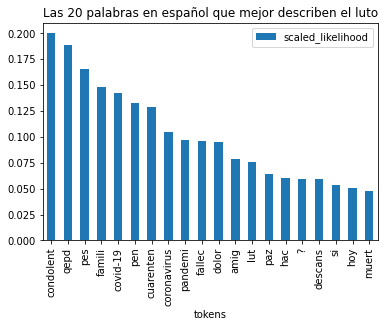

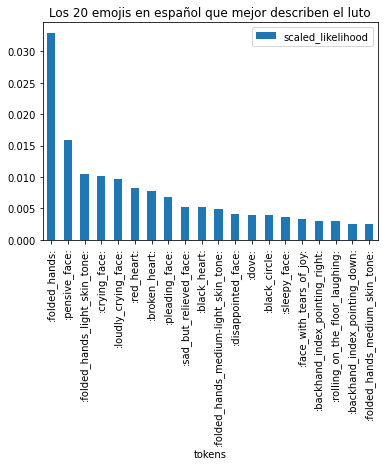

Tabla de los 20 emojis en español que mejor describen el luto


,imagen,scaled_likelihood
262,🙏,0.032964
452,😔,0.015848
265,🙏🏻,0.010460
177,😢,0.010143
356,😭,0.009667
515,❤,0.008241
121,💔,0.007765
475,🥺,0.006815
539,😥,0.005230
104,🖤,0.005230


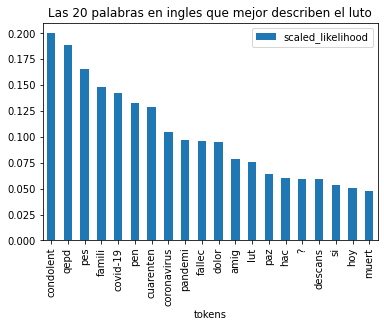

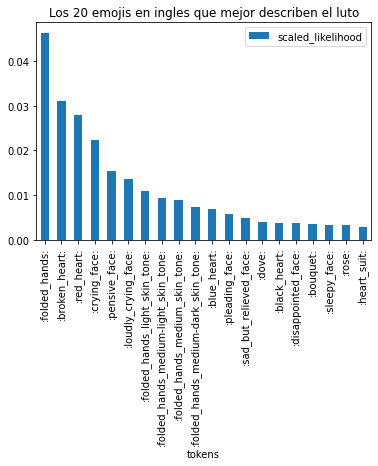

Tabla de los 20 emojis en ingles que mejor describen el luto


,imagen,scaled_likelihood
212,🙏,0.046317
94,💔,0.031131
398,❤,0.027904
144,😢,0.022399
351,😔,0.015376
287,😭,0.013667
216,🙏🏻,0.010820
220,🙏🏼,0.009301
222,🙏🏽,0.008922
218,🙏🏾,0.007403


In [575]:
visualizacion_n_palabras_mas_likely_mourning(sl_es_tweets, 20, 'español')
visualizacion_n_emojis_mas_likely_mourning(sl_es_tweets, 20, 'español')
visualizacion_n_palabras_mas_likely_mourning(sl_en_tweets, 20, 'ingles')
visualizacion_n_emojis_mas_likely_mourning(sl_en_tweets, 20, 'ingles')

## Score propuesto

In [578]:
def lista_score(tweets_tokenizado, n , idioma):
    tweets_tokenizado_slikelihood = scaled_likelihood(tweets_tokenizado)
    res = tweets_tokenizado_slikelihood\
        .drop('total_apariciones_categoria', axis = 1)\
        .set_index(['tokens', 'tag'])\
        .unstack(fill_value=0)
    res.columns = res.columns.droplevel()
    res = res.reset_index()
    res['score'] = (res['mourning']-res['no mourning'])
    res = res.sort_values(by='score', ascending = False)
    res.head(20).plot.bar(x = 'tokens', 
                          y = 'score', 
                          title = f'Los {n} tokens en {idioma} con mayor score')
    return res

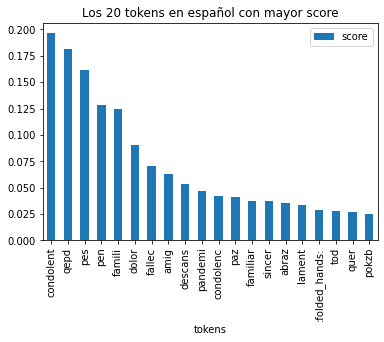

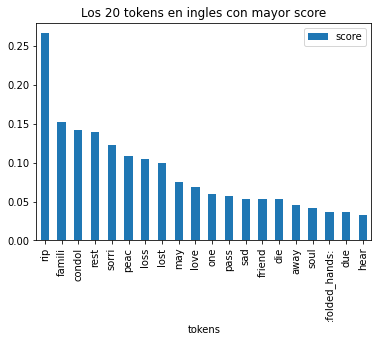

In [579]:
score_es_tweets = lista_score(tweets_es_tokenizado,20,'español')
score_en_tweets = lista_score(tweets_en_tokenizado,20,'ingles')

# Clasificadores para detectar luto

## Creacion de Features

In [535]:
def feature_representation(tweets_tokenizado, n_apariciones):
    # filtrar aquellos tokens que aparecen muy poco
    total = tweets_tokenizado\
        .groupby('tokens')\
        .agg(total_apariciones = ('index', 'count'))\
        .reset_index()
    tokens_finales = total.loc[total['total_apariciones']>=n_apariciones, 'tokens'].unique()
    
    # generacion features
    tweets_tokenizado = tweets_tokenizado\
        [tweets_tokenizado['tokens'].isin(tokens_finales)]
    tweets_tokenizado['tag'] = (tweets_tokenizado['tag']=='mourning').astype(int)
    tweets_tokenizado['indicadora'] = 1
    tweets_tokenizado_filtrado = tweets_tokenizado[['index','tag','tokens', 'indicadora']]\
        .copy()
    tweets_features = tweets_tokenizado_filtrado\
        .set_index(['index','tag','tokens'])\
        .unstack(fill_value = 0)
    tweets_features.columns = tweets_features.columns.droplevel()
    tweets_features = tweets_features.reset_index()

    return tweets_features

In [536]:
fr_es_tweets = feature_representation(tweets_es_tokenizado, 10)
fr_en_tweets = feature_representation(tweets_en_tokenizado, 10)

/home/yacirramirez/anaconda3/envs/nlp3_7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/yacirramirez/anaconda3/envs/nlp3_7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/yacirramirez/anaconda3/envs/nlp3_7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

## Division train test

In [537]:
def train_test_particion(features_base ):
    X_train, X_test, y_train, y_test = \
        train_test_split(features_base.drop(['tag', 'index'], axis =1),
                         features_base['tag'], 
                         test_size=0.33,
                         random_state=42)
    return X_train, X_test, y_train, y_test

In [538]:
X_train_en, X_test_en, y_train_en, y_test_en = train_test_particion(fr_en_tweets)
X_train_es, X_test_es, y_train_es, y_test_es = train_test_particion(fr_es_tweets)


## Entrenamiento y metricas de los clasificadores

In [539]:
def entrenar_modelos(X_train,y_train, con_emoticones = True):
    X, y = X_train.copy(), y_train.copy()
    if not con_emoticones:
        cols_sin_emojis = [col for col in X_train.columns if ':' not in col]
        X, y = X_train[cols_sin_emojis].copy(), y_train.copy()
    else:
        pass
        
    nb_clf = MultinomialNB()
    nb_clf.fit(X, y)
    
    lr_clf = LogisticRegression(random_state=0)
    lr_clf.fit(X, y)
    
    tree_clf = tree.DecisionTreeClassifier()
    tree_clf = tree_clf.fit(X, y)
    
    rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
    rf_clf.fit(X, y)
    res = {'naive_bayes': nb_clf,
           'logistic_regression': lr_clf,
           'decision_tree':tree_clf, 
           'random_forest':rf_clf}
    return res
def sacar_metricas(clf_entrenado, X_test, y_test, con_emoticones = True):
    if not con_emoticones:
        cols_sin_emojis = [col for col in X_test.columns if ':' not in col]
        y_pred = clf_entrenado.predict(X_test[cols_sin_emojis])
    else:
        y_pred = clf_entrenado.predict(X_test)
    y_true = y_test
    
    res =  classification_report(y_true,
                                 y_pred,
                                 labels = [0,1],
                                 target_names=['Clase 0', 'Clase 1'])
    print(res)
    res =  classification_report(y_true,
                                 y_pred,
                                 labels = [0,1],
                                 target_names=['Clase 0', 'Clase 1'],
                                 output_dict = True
                                )
    return res
def sacar_metricas_para_cada_modelo(dict_clf, X_test, y_test, con_emoticones = True):
    resultados = {}
    for clf_name in dict_clf:
        print()
        print(clf_name)
        print()
        resultados[clf_name] = sacar_metricas(dict_clf[clf_name], X_test, y_test, con_emoticones)
        print()
    return resultados

### Resultados para tweets en español

In [540]:

modelos_con_emojis_es = entrenar_modelos(X_train_es, y_train_es, True)
modelos_sin_emojis_es = entrenar_modelos(X_train_es, y_train_es, False)

print('Resultados CON emojis')
resultados_con_emojis_es = sacar_metricas_para_cada_modelo(modelos_con_emojis_es,X_test_es,y_test_es, True)
print()
print('Resultados SIN emojis')
resultados_sin_emojis_es = sacar_metricas_para_cada_modelo(modelos_sin_emojis_es,X_test_es,y_test_es, False)

Resultados CON emojis

naive_bayes

              precision    recall  f1-score   support

     Clase 0       0.84      0.85      0.85      2175
     Clase 1       0.84      0.83      0.84      2079

    accuracy                           0.84      4254
   macro avg       0.84      0.84      0.84      4254
weighted avg       0.84      0.84      0.84      4254



logistic_regression

              precision    recall  f1-score   support

     Clase 0       0.90      0.94      0.92      2175
     Clase 1       0.93      0.89      0.91      2079

    accuracy                           0.91      4254
   macro avg       0.91      0.91      0.91      4254
weighted avg       0.91      0.91      0.91      4254



decision_tree

              precision    recall  f1-score   support

     Clase 0       0.87      0.88      0.88      2175
     Clase 1       0.88      0.86      0.87      2079

    accuracy                           0.87      4254
   macro avg       0.87      0.87      0.87      425

### Resultados para tweets en inglés

In [541]:
modelos_con_emojis_en = entrenar_modelos(X_train_en, y_train_en, True)
modelos_sin_emojis_en = entrenar_modelos(X_train_en, y_train_en, False)

print('Resultados CON emojis')
resultados_con_emojis_en = sacar_metricas_para_cada_modelo(modelos_con_emojis_en,X_test_en,y_test_en, True)
print()
print('Resultados SIN emojis')
resultados_sin_emojis_en = sacar_metricas_para_cada_modelo(modelos_sin_emojis_en,X_test_en,y_test_en, False)

Resultados CON emojis

naive_bayes

              precision    recall  f1-score   support

     Clase 0       0.86      0.87      0.87      1977
     Clase 1       0.85      0.84      0.85      1770

    accuracy                           0.86      3747
   macro avg       0.86      0.86      0.86      3747
weighted avg       0.86      0.86      0.86      3747



logistic_regression

              precision    recall  f1-score   support

     Clase 0       0.87      0.92      0.90      1977
     Clase 1       0.91      0.85      0.88      1770

    accuracy                           0.89      3747
   macro avg       0.89      0.89      0.89      3747
weighted avg       0.89      0.89      0.89      3747



decision_tree

              precision    recall  f1-score   support

     Clase 0       0.85      0.88      0.86      1977
     Clase 1       0.86      0.83      0.84      1770

    accuracy                           0.85      3747
   macro avg       0.85      0.85      0.85      374

### Comparacion de resultados

In [591]:
pd.DataFrame.from_dict(resultados_con_emojis_es, orient = 'index')

,Clase 0,Clase 1,accuracy,macro avg,weighted avg
naive_bayes,"{'precision': 0.8408163265306122, 'recall': 0....","{'precision': 0.8433382137628112, 'recall': 0....",0.842031,"{'precision': 0.8420772701467116, 'recall': 0....","{'precision': 0.8420488144374627, 'recall': 0...."
logistic_regression,"{'precision': 0.897887323943662, 'recall': 0.9...","{'precision': 0.9318869828456104, 'recall': 0....",0.913728,"{'precision': 0.9148871533946362, 'recall': 0....","{'precision': 0.9145035183153476, 'recall': 0...."
decision_tree,"{'precision': 0.8721668177697189, 'recall': 0....","{'precision': 0.87744140625, 'recall': 0.86435...",0.874706,"{'precision': 0.8748041120098595, 'recall': 0....","{'precision': 0.8747445962019015, 'recall': 0...."
random_forest,"{'precision': 0.6424242424242425, 'recall': 0....","{'precision': 0.9423480083857443, 'recall': 0....",0.709685,"{'precision': 0.7923861254049933, 'recall': 0....","{'precision': 0.7890019362263022, 'recall': 0...."


In [587]:
list(resultados_con_emojis_es)

['naive_bayes', 'logistic_regression', 'decision_tree', 'random_forest']

In [582]:
resultados = \
    {'resultados_español':resultados_con_emojis_es,
     'resultados_ingles':resultados_con_emojis_en,
     'resultados_sin_emojis_español':resultados_sin_emojis_es,
     'resultados_sin_emojis_ingles':resultados_sin_emojis_en
    }
def comparacion_metricas_entre_clasificadores(resultados):
    for key in resultados.keys():
        data = []
        for clf_name in  resultados[key]:
            
        print(key.upper())
def comparacion_metricas_entre_emoji_noEmoji(resultados):
    
data
resultados_con_emojis_es.keys()


dict_keys(['naive_bayes', 'logistic_regression', 'decision_tree', 'random_forest'])

# Feature Importance

In [543]:
def sacar_feature_importance_lr(lr_entrenado, X_test, con_emoticones = True):
    features = X_test.columns
    if not con_emoticones:
        features = [col for col in X_test.columns if ':' not in col]
    coefs = [coef for coef in lr_entrenado.coef_[0]]
    importance = pd\
        .DataFrame(list(zip(features, coefs)), 
                   columns = ['features', 'importance'])\
        .sort_values(by = 'importance', ascending = False)
    importance[:10].plot.bar(x = 'features',y='importance', title = 'Logistic Regression Biggest 10 coeficients (signed)')
    plt.show()

In [544]:
def sacar_feature_importance_rf(rf_entrenado, X_test, con_emoticones = True):
    features = X_test.columns
    if not con_emoticones:
        features = [col for col in X_test.columns if ':' not in col]
    coefs = [coef for coef in rf_entrenado.feature_importances_]
    importance = pd\
        .DataFrame(list(zip(features, coefs)), 
                   columns = ['features', 'importance'])\
        .sort_values(by = 'importance', ascending = False)
    importance[:10].plot.bar(x = 'features',y='importance', title = 'Random Forest Biggest 10 Impurity Importances')
    plt.show()

## Logistic Regression Importances

ESPAÑOL CON EMOJIS


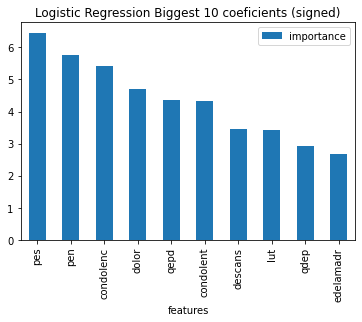

In [545]:
print('ESPAÑOL CON EMOJIS')
sacar_feature_importance_lr(modelos_con_emojis_es['logistic_regression'], X_test_es)

ESPAÑOL SIN EMOJIS


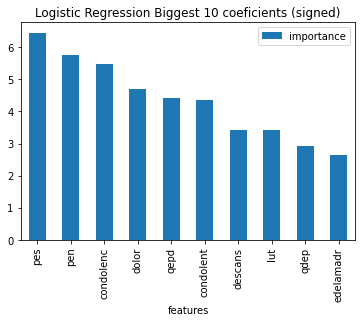

In [546]:
print('ESPAÑOL SIN EMOJIS')
sacar_feature_importance_lr(modelos_sin_emojis_es['logistic_regression'], X_test_es, False)

INGLES CON EMOJIS


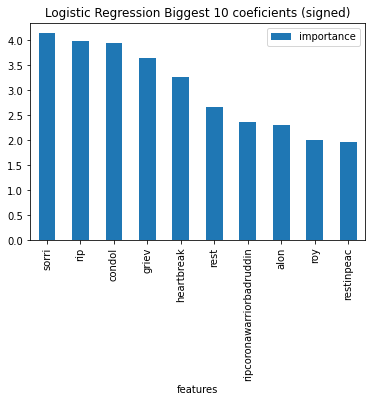

In [547]:
print('INGLES CON EMOJIS')
sacar_feature_importance_lr(modelos_con_emojis_en['logistic_regression'], X_test_en)

INGLES SIN EMOJIS


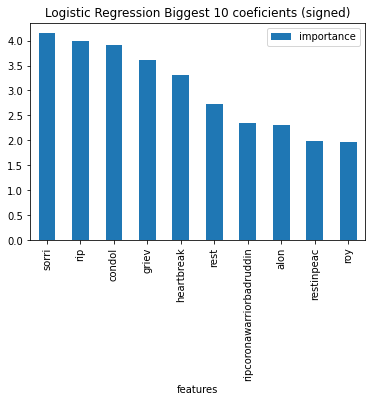

In [548]:
print('INGLES SIN EMOJIS')
sacar_feature_importance_lr(modelos_sin_emojis_en['logistic_regression'], X_test_en, False)

## Random Forest Importances

ESPAÑOL CON EMOJIS


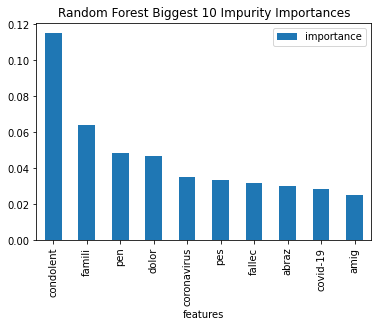

In [549]:
print('ESPAÑOL CON EMOJIS')
sacar_feature_importance_rf(modelos_con_emojis_es['random_forest'], X_test_es)

ESPAÑOL SIN EMOJIS


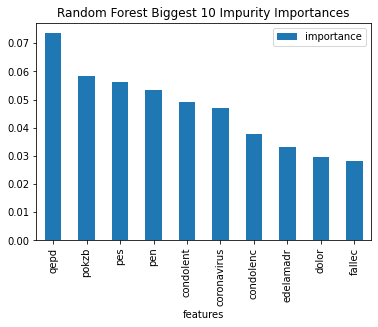

In [550]:
print('ESPAÑOL SIN EMOJIS')
sacar_feature_importance_rf(modelos_sin_emojis_es['random_forest'], X_test_es, False)

INGLES CON EMOJIS


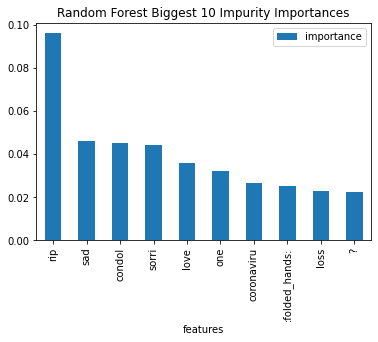

In [551]:
print('INGLES CON EMOJIS')
sacar_feature_importance_rf(modelos_con_emojis_en['random_forest'], X_test_en)

INGLES SIN EMOJIS


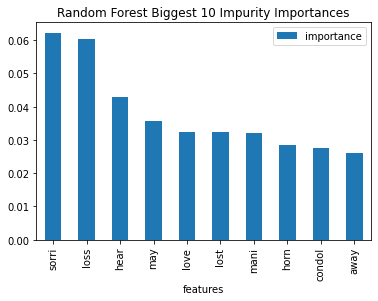

In [552]:
print('INGLES SIN EMOJIS')
sacar_feature_importance_rf(modelos_sin_emojis_en['random_forest'], X_test_en, False)

In [412]:
repr(negrilla)

"'𝗽𝗲𝘀𝗮𝗿'"